<a href="https://colab.research.google.com/github/GabCopetti/Chest-X-Rays-Binary-Classification/blob/main/Chest_XRays_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
## 1. Setting up environment
***

In [1]:
#Installing specific Python version
!sudo apt-get install python3.10
!python --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Python 3.10.12


In [2]:
#Installing necessary packages

#Disabling output
%%capture
!pip install torch==2.3.1+cu121
!pip install torchvision==0.18.1+cu121
!pip install datasets==2.20.0
!pip install matplotlib==3.7.1
!pip install requests==2.32.3
!pip install torchmetrics==1.4.0.post0
!pip install tqdm==4.66.4
!pip install sklearn==2.2.0

In [3]:
#Importing libraries

#Torch
import torch
from torch import nn

#Torchvision
import torchvision
from torchvision.transforms import functional as F

#Import datasets from Hugging Face
import datasets
from datasets import load_dataset

#Matplotlib
import matplotlib.pyplot as plt

#Importing Path to download helper functions from Learn PyTorch repo
import requests
from pathlib import Path

#Importing DataLoader
from torch.utils.data import DataLoader

#Importing tqdm for progress bar
from tqdm.auto import tqdm

#To use in the plotting function
from typing import Dict, List

#For evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [5]:
#Import accuracy metric
from helper_functions import accuracy_fn

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

***
## 2. Data preparation
***

In [7]:
#Loading test dataset
test_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]

In [8]:
#Changing format to torch.Tensor and losing image_file_path
format = {'type': 'torch', 'device': torch.device(device), 'columns': ['image','labels'], 'format_kwargs':{'dtype': torch.float}}

test_dataset.set_format(**format )

In [9]:
def transform(example):
    #Transforming channel number = 3 to channnel number = 1
    example['image'] = F.rgb_to_grayscale(example['image'], num_output_channels=1)
    #Converting pixel values from 0-255 to 0-1
    example['image'] = example['image']/255
    return example

In [10]:
#Applying transformations to set
test_dataset = test_dataset.map(transform, batched= True, batch_size=32)

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

In [11]:
#Setting up DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn the training data into batches
test_dataloader = DataLoader((test_dataset),
    batch_size=BATCH_SIZE,
    shuffle=False # don't have to shuffle the test data
)

print(f"Dataloaders: {test_dataloader}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7d88f6c03760>
Length of test dataloader: 10 batches of 64


***
## 3. Setting up model classes
***

### Linear models

In [12]:
#Two linear layers
class XRAYS_linear2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [13]:
#Three linear layers
class XRAYS_linear3(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [14]:
#Four linear layers
class XRAYS_linear4(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Non-linear models

In [15]:
# Two layers
class XRAYS_linear2ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [16]:
# Three layers
class XRAYS_linear3ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [17]:
# Four layers
class XRAYS_linear4ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


### Convolutional Neural Networks

In [18]:
# Create a convolutional neural network

#One linear layer at the end

class XRAYS_CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25600,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [19]:
#Two linear layers at the end

class XRAYS_CNN2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25600,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)

        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

***
## 4. Evaluation function
***

In [20]:
#Evaluation function
def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    y_true = []
    y_pred = []
    test_acc, test_f1 = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for entry in data_loader:
            # Send data to GPU
            X = entry['image'].to(device)
            y = entry['labels'].to(device)
            y_true.append(y)

            # 1. Forward pass
            test_logits = model(X).squeeze().to(device)
            test_pred = torch.round(torch.sigmoid(test_logits)).to(device)
            y_pred.append(test_pred)

            # 2. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Adjust metrics and return
        y_true = torch.cat(y_true).to('cpu')
        y_true = torch.Tensor.numpy(y_true)
        y_pred = torch.cat(y_pred).to('cpu')
        y_pred = torch.Tensor.numpy(y_pred)
        test_acc /= len(data_loader)
        test_f1 += f1_score(y_true=y_true, y_pred=y_pred)

        results = {
            "test_acc": test_acc,
            "test_f1": test_f1
        }

        return results, y_true, y_pred

## 5. Linear models

### Batch size: 32

#### Model 20

In [28]:
loaded_model_20 = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_20.to(device)

# Load model state dict
loaded_model_20.load_state_dict(torch.load('models/model_20.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_20.to(device)

print(f"Loaded model:\n{loaded_model_20}")
print(f"Model on device:\n{next(loaded_model_20.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [29]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_20, y_test, y_test_pred_model_20 = test(data_loader=test_dataloader,
                                                            model=loaded_model_20,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [30]:
test_results_model_20

{'test_acc': 93.75, 'test_f1': 0.9523809523809522}

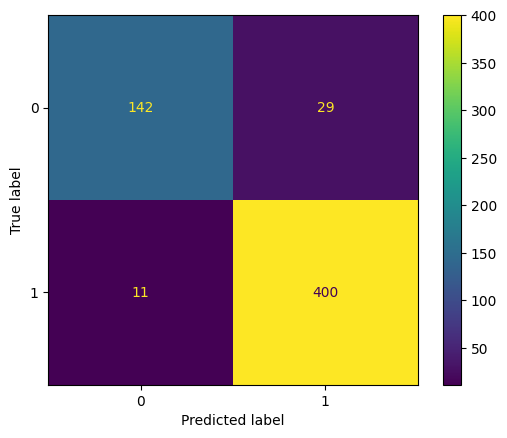

In [31]:
cm = confusion_matrix(y_test, y_test_pred_model_20)
ConfusionMatrixDisplay(cm).plot()

#### Model 23 (weighed loss function)

In [34]:
loaded_model_23 = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_23.to(device)

# Load model state dict
loaded_model_23.load_state_dict(torch.load('models/model_23.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_23.to(device)

print(f"Loaded model:\n{loaded_model_23}")
print(f"Model on device:\n{next(loaded_model_23.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [35]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_23, y_test, y_test_pred_model_23 = test(data_loader=test_dataloader,
                                                            model=loaded_model_23,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [36]:
test_results_model_23

{'test_acc': 90.67708333333334, 'test_f1': 0.9379652605459057}

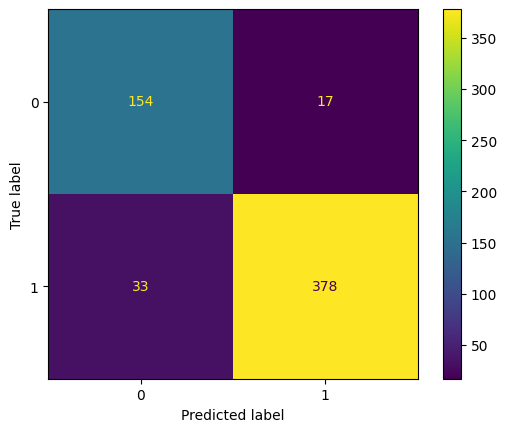

In [37]:
cm = confusion_matrix(y_test, y_test_pred_model_23)
ConfusionMatrixDisplay(cm).plot()

### Batch size: 64

#### Model 20b

In [ ]:
loaded_model_20b = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_20b.to(device)

# Load model state dict
loaded_model_20b.load_state_dict(torch.load('models/model_20b.pth'))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_20b.to(device)

print(f"Loaded model:\n{loaded_model_20b}")
print(f"Model on device:\n{next(loaded_model_20b.parameters()).device}")


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_20b, y_test, y_test_pred_model_20b = test(data_loader=test_dataloader,
                                                            model=loaded_model_20b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_20b

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_20b)
ConfusionMatrixDisplay(cm).plot()

#### Model 23b (weighed loss function)

In [ ]:
loaded_model_23b = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_23b.to(device)

# Load model state dict
loaded_model_23b.load_state_dict(torch.load('models/model_23.pth'))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_23b.to(device)

print(f"Loaded model:\n{loaded_model_23b}")
print(f"Model on device:\n{next(loaded_model_23b.parameters()).device}")


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_23b, y_test, y_test_pred_model_23b = test(data_loader=test_dataloader,
                                                            model=loaded_model_23b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_23b

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_23b)
ConfusionMatrixDisplay(cm).plot()

## 6. Linear + ReLU models

### Batch size: 32

#### Model 21

In [40]:
loaded_model_21 = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_21.load_state_dict(torch.load('models/model_21.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_21.to(device)

print(f"Loaded model:\n{loaded_model_21}")
print(f"Model on device:\n{next(loaded_model_21.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [41]:
test_results_model_21, y_test, y_test_pred_model_21 = test(data_loader=test_dataloader,
                                                            model=loaded_model_21,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [42]:
test_results_model_21

{'test_acc': 93.75, 'test_f1': 0.9528301886792453}

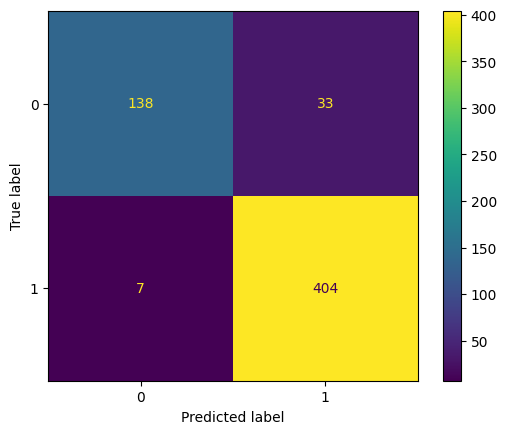

In [43]:
cm = confusion_matrix(y_test, y_test_pred_model_21)
ConfusionMatrixDisplay(cm).plot()

#### Model 24 (weighed loss function)

In [44]:
loaded_model_24 = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_24.load_state_dict(torch.load('models/model_24.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_24.to(device)

print(f"Loaded model:\n{loaded_model_24}")
print(f"Model on device:\n{next(loaded_model_24.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [45]:
test_results_model_24, y_test, y_test_pred_model_24 = test(data_loader=test_dataloader,
                                                            model=loaded_model_24,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [46]:
test_results_model_24

{'test_acc': 93.4375, 'test_f1': 0.9498806682577566}

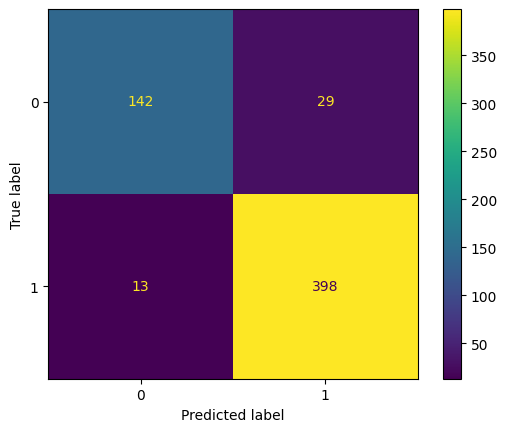

In [47]:
cm = confusion_matrix(y_test, y_test_pred_model_24)
ConfusionMatrixDisplay(cm).plot()

### Batch size: 64

#### Model 21b

In [ ]:
loaded_model_21b = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_21b.load_state_dict(torch.load('models/model_21b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_21b.to(device)

print(f"Loaded model:\n{loaded_model_21b}")
print(f"Model on device:\n{next(loaded_model_21b.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [ ]:
test_results_model_21b, y_test, y_test_pred_model_21b = test(data_loader=test_dataloader,
                                                            model=loaded_model_21b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_21b

{'test_acc': 93.75, 'test_f1': 0.9528301886792453}

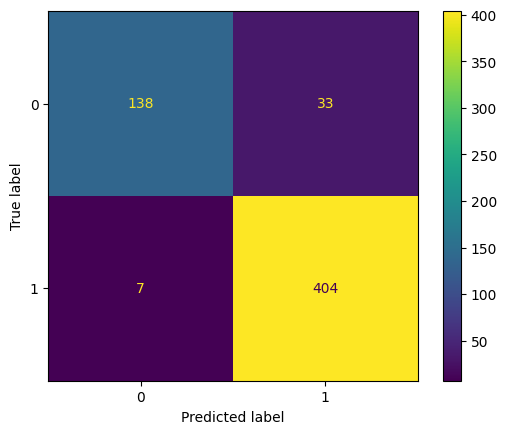

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_21b)
ConfusionMatrixDisplay(cm).plot()

#### Model 24b (weighed loss function)

In [ ]:
loaded_model_24b = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_24b.load_state_dict(torch.load('models/model_24b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_24b.to(device)

print(f"Loaded model:\n{loaded_model_24b}")
print(f"Model on device:\n{next(loaded_model_24b.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [ ]:
test_results_model_24b, y_test, y_test_pred_model_24b = test(data_loader=test_dataloader,
                                                            model=loaded_model_24b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_24b

{'test_acc': 93.4375, 'test_f1': 0.9498806682577566}

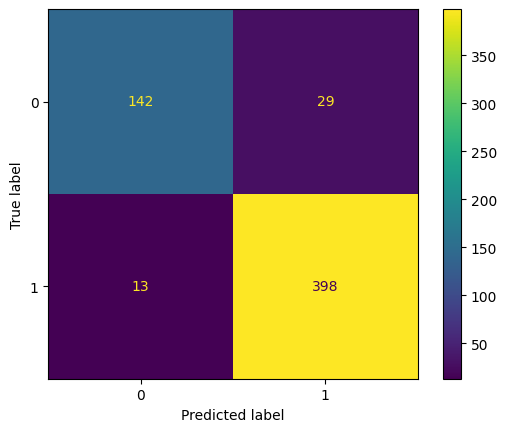

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_24b)
ConfusionMatrixDisplay(cm).plot()

## 7. CNN models

### Batch size: 32

#### Model 22

In [49]:
loaded_model_22 = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_22.to(device)
# Load model state dict
loaded_model_22.load_state_dict(torch.load('models/model_22.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_22.to(device)

print(f"Loaded model:\n{loaded_model_22}")
print(f"Model on device:\n{next(loaded_model_22.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [50]:
test_results_model_22, y_test, y_test_pred_model_22 = test(data_loader=test_dataloader,
                                                            model=loaded_model_22,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [51]:
test_results_model_22

{'test_acc': 93.4375, 'test_f1': 0.9497607655502392}

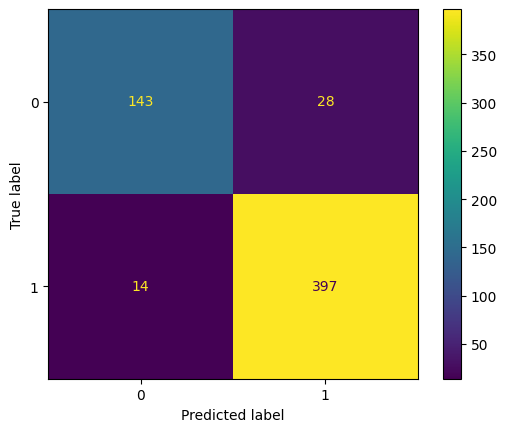

In [52]:
cm = confusion_matrix(y_test, y_test_pred_model_22)
ConfusionMatrixDisplay(cm).plot()

#### Model 25 (weighed loss function)

In [53]:
loaded_model_25 = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_25.to(device)
# Load model state dict
loaded_model_25.load_state_dict(torch.load('models/model_25.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_25.to(device)

print(f"Loaded model:\n{loaded_model_25}")
print(f"Model on device:\n{next(loaded_model_25.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [54]:
test_results_model_25, y_test, y_test_pred_model_25 = test(data_loader=test_dataloader,
                                                            model=loaded_model_25,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [55]:
test_results_model_25

{'test_acc': 93.02083333333334, 'test_f1': 0.9578820697954272}

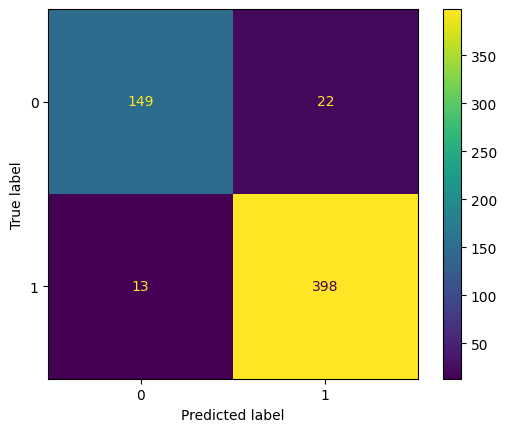

In [56]:
cm = confusion_matrix(y_test, y_test_pred_model_25)
ConfusionMatrixDisplay(cm).plot()

### Batch size: 64

#### Model 22b

In [ ]:
loaded_model_22b = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_22b.to(device)
# Load model state dict
loaded_model_22b.load_state_dict(torch.load('models/model_22b.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_22b.to(device)

print(f"Loaded model:\n{loaded_model_22b}")
print(f"Model on device:\n{next(loaded_model_22b.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [ ]:
test_results_model_22b, y_test, y_test_pred_model_22b = test(data_loader=test_dataloader,
                                                            model=loaded_model_22b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_22b

{'test_acc': 93.4375, 'test_f1': 0.9497607655502392}

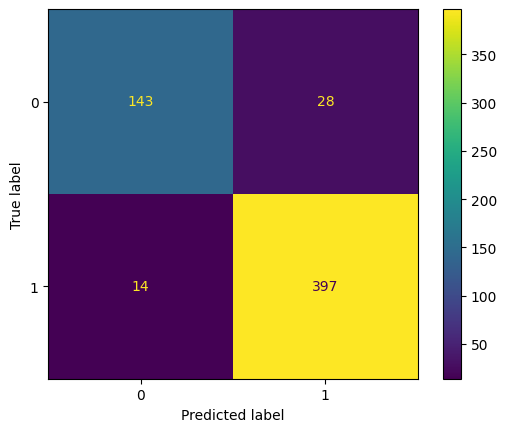

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_22b)
ConfusionMatrixDisplay(cm).plot()

#### Model 25b (weighed loss function)

In [ ]:
loaded_model_25b = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_25b.to(device)
# Load model state dict
loaded_model_25b.load_state_dict(torch.load('models/model_25b.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_25b.to(device)

print(f"Loaded model:\n{loaded_model_25b}")
print(f"Model on device:\n{next(loaded_model_25b.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [ ]:
test_results_model_25b, y_test, y_test_pred_model_25b = test(data_loader=test_dataloader,
                                                            model=loaded_model_25b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [ ]:
test_results_model_25b

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_model_25b)
ConfusionMatrixDisplay(cm).plot()